In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

In [81]:
# Change this path to the run you want to analyze
run_dirs = os.listdir("scaling_results")
run_dirs.sort()
# run_dir = Path("scaling_results/strong_20260116_142012")
strong_run_dirs = [d for d in run_dirs if "strong" in d]
strong_run_dir = "scaling_results" / Path(strong_run_dirs[-1])
weak_run_dirs = [d for d in run_dirs if "weak" in d]
weak_run_dir = "scaling_results" / Path(weak_run_dirs[-1])

strong_img_dir = Path("scaling_results/strong")
weak_img_dir = Path("scaling_results/weak")
os.makedirs(strong_img_dir, exist_ok=True)
os.makedirs(weak_img_dir, exist_ok=True)

In [82]:
csv_path = strong_run_dir / "summary.csv"

df = pd.read_csv(csv_path)

# Sort for safety
df = df.sort_values("ranks").reset_index(drop=True)

# Group by ranks and compute mean and std for metrics
df_agg = df.groupby("ranks").agg({
    "wall_seconds": ["mean", "std"],
    "particle_steps_per_sec": ["mean", "std"],
    "npt_per_rank": "first",  # Should be same for all runs with same rank
    "total_particles": "first",  # Should be same for all runs with same rank
}).reset_index()

# Flatten column names
df_agg.columns = ["ranks", "wall_seconds_mean", "wall_seconds_std", 
                   "particle_steps_per_sec_mean", "particle_steps_per_sec_std",
                   "npt_per_rank", "total_particles"]

# Sort by ranks
df_agg = df_agg.sort_values("ranks").reset_index(drop=True)

display(df_agg.head())

,ranks,wall_seconds_mean,wall_seconds_std,particle_steps_per_sec_mean,particle_steps_per_sec_std,npt_per_rank,total_particles
0,8,148.454630,1.370010,7.063675e+06,64853.017136,327680,2621440
1,16,82.779220,1.192743,1.266888e+07,181217.516491,163840,2621440
2,32,48.111154,0.607125,2.179717e+07,273806.808179,81920,2621440
3,64,29.480438,0.552189,3.557687e+07,667374.569480,40960,2621440
4,128,23.283217,0.214304,4.503824e+07,412994.389293,20480,2621440


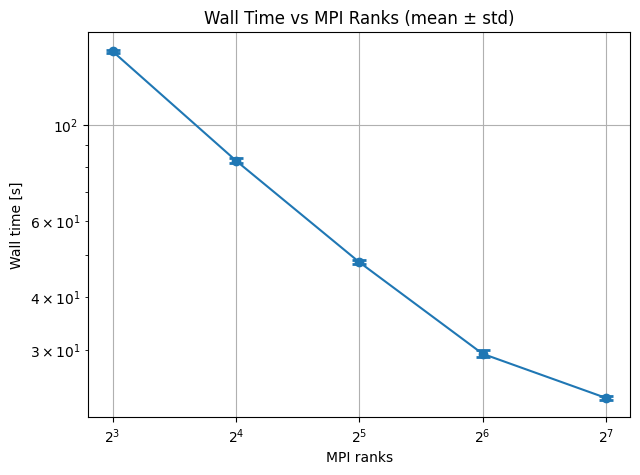

In [83]:
plt.figure()
plt.errorbar(df_agg["ranks"], df_agg["wall_seconds_mean"], 
             yerr=df_agg["wall_seconds_std"], marker="o", capsize=5, capthick=2)
plt.xscale("log", base=2)
plt.yscale("log")

plt.xlabel("MPI ranks")
plt.ylabel("Wall time [s]")
plt.title("Wall Time vs MPI Ranks (mean ± std)")
plt.savefig(strong_img_dir / "wall_time_vs_ranks.png", dpi=300)

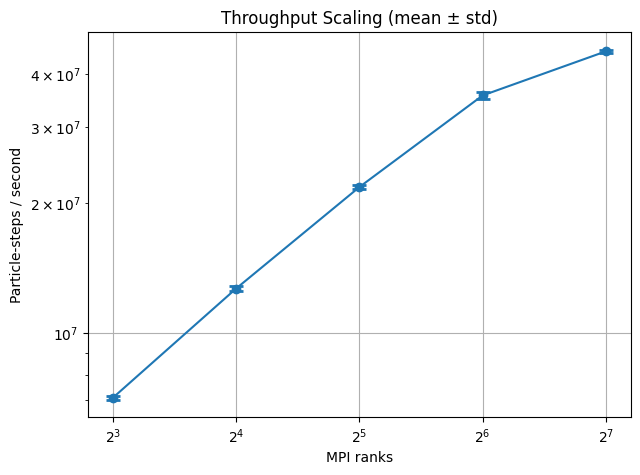

In [84]:
plt.figure()
plt.errorbar(df_agg["ranks"], df_agg["particle_steps_per_sec_mean"], 
             yerr=df_agg["particle_steps_per_sec_std"], marker="o", capsize=5, capthick=2)
plt.xscale("log", base=2)
plt.yscale("log")

plt.xlabel("MPI ranks")
plt.ylabel("Particle-steps / second")
plt.title("Throughput Scaling (mean ± std)")
plt.savefig(strong_img_dir / "throughput_scaling.png", dpi=300)

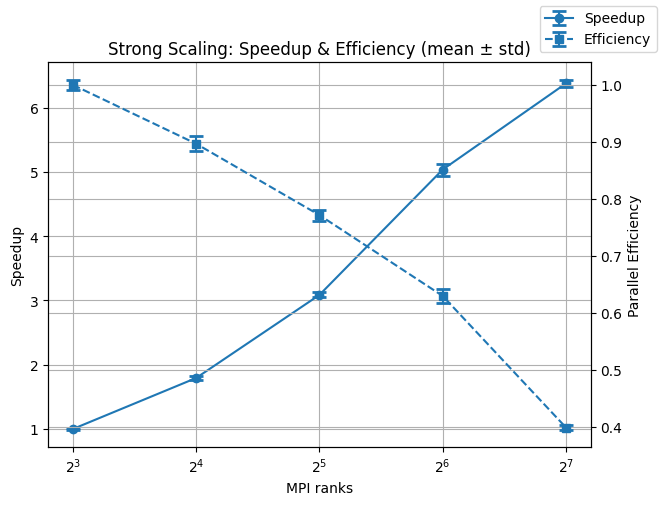

In [96]:
# Reference run: smallest rank count (use mean)
ref_mean = df_agg.iloc[0]["wall_seconds_mean"]

# Calculate speedup and efficiency using mean values
df_agg["speedup_mean"] = ref_mean / df_agg["wall_seconds_mean"]
df_agg["speedup_std"] = ref_mean * df_agg["wall_seconds_std"] / (df_agg["wall_seconds_mean"] ** 2)

ref_ranks = df_agg.iloc[0]["ranks"]
df_agg["efficiency_mean"] = df_agg["speedup_mean"] / (df_agg["ranks"] / ref_ranks)
df_agg["efficiency_std"] = df_agg["speedup_std"] / (df_agg["ranks"] / ref_ranks)

fig, ax1 = plt.subplots()

ax1.errorbar(df_agg["ranks"], df_agg["speedup_mean"], 
             yerr=df_agg["speedup_std"], marker="o", capsize=5, capthick=2, label="Speedup")
ax1.set_xlabel("MPI ranks")
ax1.set_ylabel("Speedup")

ax2 = ax1.twinx()
ax2.errorbar(df_agg["ranks"], df_agg["efficiency_mean"], 
             yerr=df_agg["efficiency_std"], marker="s", linestyle="--", 
             capsize=5, capthick=2, label="Efficiency")
ax2.set_ylabel("Parallel Efficiency")
ax2.set_xscale("log", base=2)

fig.legend(loc="upper right")
plt.title("Strong Scaling: Speedup & Efficiency (mean ± std)")
plt.savefig(strong_img_dir / "speedup_efficiency.png", dpi=300)

In [73]:
display(df_agg[[
    "ranks",
    "npt_per_rank",
    "total_particles",
    "wall_seconds_mean",
    "wall_seconds_std",
    "particle_steps_per_sec_mean",
    "particle_steps_per_sec_std",
    "efficiency_mean" if "efficiency_mean" in df_agg.columns else "weak_efficiency_mean"
]])

,ranks,npt_per_rank,total_particles,wall_seconds_mean,wall_seconds_std,particle_steps_per_sec_mean,particle_steps_per_sec_std,efficiency_mean
0,8,327680,2621440,148.454630,1.370010,7.063675e+06,64853.017136,1.000000
1,16,163840,2621440,82.779220,1.192743,1.266888e+07,181217.516491,0.896690
2,32,81920,2621440,48.111154,0.607125,2.179717e+07,273806.808179,0.771415
3,64,40960,2621440,29.480438,0.552189,3.557687e+07,667374.569480,0.629462
4,128,20480,2621440,23.283217,0.214304,4.503824e+07,412994.389293,0.398502


In [74]:
csv_path = weak_run_dir / "summary.csv"

df = pd.read_csv(csv_path)

# Sort for safety
df = df.sort_values("ranks").reset_index(drop=True)

# Group by ranks and compute mean and std for metrics
df_agg = df.groupby("ranks").agg({
    "wall_seconds": ["mean", "std"],
    "particle_steps_per_sec": ["mean", "std"],
    "npt_per_rank": "first",  # Should be same for all runs with same rank
    "total_particles": "first",  # Should be same for all runs with same rank
}).reset_index()

# Flatten column names
df_agg.columns = ["ranks", "wall_seconds_mean", "wall_seconds_std", 
                   "particle_steps_per_sec_mean", "particle_steps_per_sec_std",
                   "npt_per_rank", "total_particles"]

# Sort by ranks
df_agg = df_agg.sort_values("ranks").reset_index(drop=True)

display(df_agg.head())

,ranks,wall_seconds_mean,wall_seconds_std,particle_steps_per_sec_mean,particle_steps_per_sec_std,npt_per_rank,total_particles
0,8,9.795798,0.526430,3.351768e+06,1.858923e+05,10240,81920
1,16,11.035313,1.592968,6.015927e+06,8.019640e+05,10240,163840
2,32,11.096602,1.419631,1.193325e+07,1.422886e+06,10240,327680
3,64,11.718167,0.102191,2.237187e+07,1.954951e+05,10240,655360
4,128,15.397807,0.620277,3.408715e+07,1.401118e+06,10240,1310720


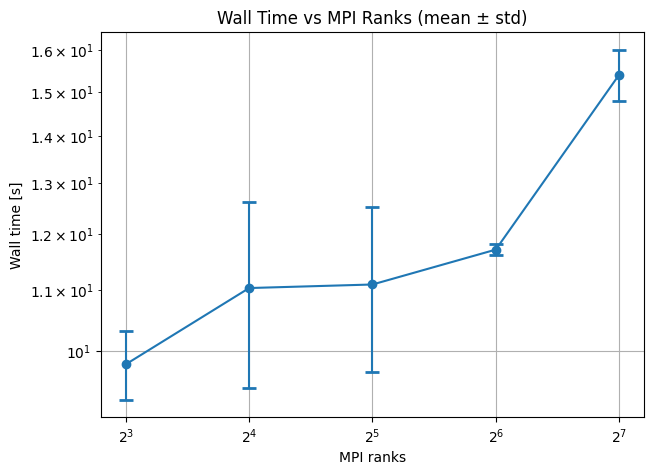

In [75]:
plt.figure()
plt.errorbar(df_agg["ranks"], df_agg["wall_seconds_mean"], 
             yerr=df_agg["wall_seconds_std"], marker="o", capsize=5, capthick=2)
plt.xscale("log", base=2)
plt.yscale("log")

plt.xlabel("MPI ranks")
plt.ylabel("Wall time [s]")
plt.title("Wall Time vs MPI Ranks (mean ± std)")
plt.savefig(weak_img_dir / "wall_time_vs_ranks.png", dpi=300)

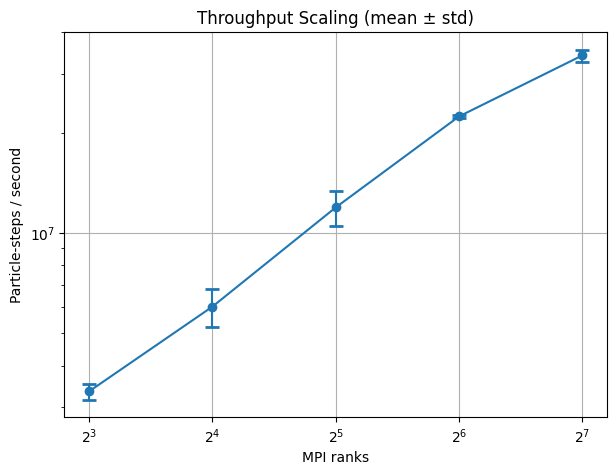

In [76]:
plt.figure()
plt.errorbar(df_agg["ranks"], df_agg["particle_steps_per_sec_mean"], 
             yerr=df_agg["particle_steps_per_sec_std"], marker="o", capsize=5, capthick=2)
plt.xscale("log", base=2)
plt.yscale("log")

plt.xlabel("MPI ranks")
plt.ylabel("Particle-steps / second")
plt.title("Throughput Scaling (mean ± std)")
plt.savefig(weak_img_dir / "throughput_scaling.png", dpi=300)

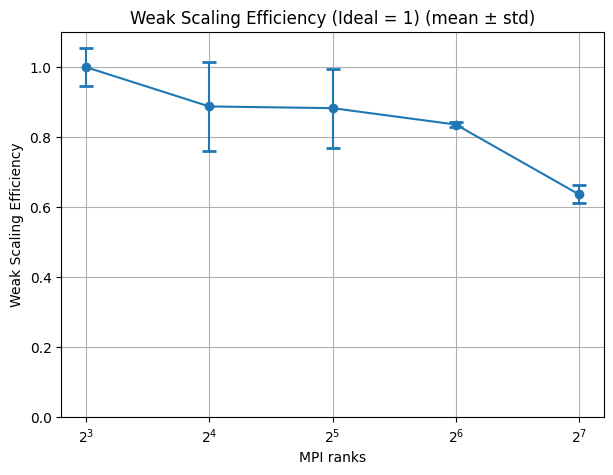

In [77]:
t_ref_mean = df_agg.iloc[0]["wall_seconds_mean"]
df_agg["weak_efficiency_mean"] = t_ref_mean / df_agg["wall_seconds_mean"]
df_agg["weak_efficiency_std"] = t_ref_mean * df_agg["wall_seconds_std"] / (df_agg["wall_seconds_mean"] ** 2)

plt.figure()
plt.errorbar(df_agg["ranks"], df_agg["weak_efficiency_mean"], 
             yerr=df_agg["weak_efficiency_std"], marker="o", capsize=5, capthick=2)
plt.xscale("log", base=2)

plt.xlabel("MPI ranks")
plt.ylabel("Weak Scaling Efficiency")
plt.title("Weak Scaling Efficiency (Ideal = 1) (mean ± std)")
plt.ylim(0, 1.1)
plt.savefig(weak_img_dir / "weak_scaling_efficiency.png", dpi=300)

In [78]:
display(df_agg[[
    "ranks",
    "npt_per_rank",
    "total_particles",
    "wall_seconds_mean",
    "wall_seconds_std",
    "particle_steps_per_sec_mean",
    "particle_steps_per_sec_std",
    "efficiency_mean" if "efficiency_mean" in df_agg.columns else "weak_efficiency_mean"
]])

,ranks,npt_per_rank,total_particles,wall_seconds_mean,wall_seconds_std,particle_steps_per_sec_mean,particle_steps_per_sec_std,weak_efficiency_mean
0,8,10240,81920,9.795798,0.526430,3.351768e+06,1.858923e+05,1.000000
1,16,10240,163840,11.035313,1.592968,6.015927e+06,8.019640e+05,0.887677
2,32,10240,327680,11.096602,1.419631,1.193325e+07,1.422886e+06,0.882775
3,64,10240,655360,11.718167,0.102191,2.237187e+07,1.954951e+05,0.835950
4,128,10240,1310720,15.397807,0.620277,3.408715e+07,1.401118e+06,0.636181
